In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split,StratifiedKFold
import os
import keras
from keras import backend as K
from keras.utils import Sequence
from PIL import Image
import cv2
import albumentations
import segmentation_models as sm
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D , MaxPool2D, UpSampling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, add
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from classification_models import Classifiers
from tqdm import tqdm_notebook
import keras.callbacks as callbacks
import tensorflow as tf
import seaborn as sns
import shutil

from mask_functions import mask2rle

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
epochs = 100
batch_size = 28
swa_nb = epochs-5

lr = 0.001
image_size,h,w = 128,128,128
channels = 3


train_root_dir = './results/train/'
mask_root_dir = './results/masks/'
test_root_dir = './results/test/'


model_name = './res50attn_Rev2'

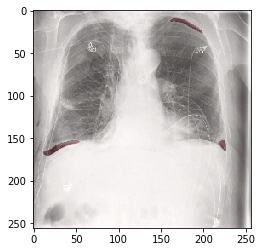

In [3]:
im_path = './results/train/1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487.png'
mk_path = im_path.replace('train','masks')

im = Image.open(im_path)
im = np.uint8(im)

mk = Image.open(mk_path)
mk = np.uint8(mk)

plt.imshow(im,cmap = 'gray')
plt.imshow(mk,alpha = 0.3,cmap='Reds')

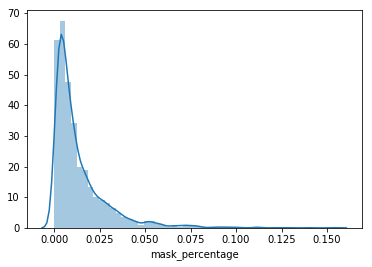

In [4]:
all_mk = glob.glob(mask_root_dir+'*')
check = pd.DataFrame()
check['file_names'] = all_mk
check['mask_percentage'] = 0
check.set_index('file_names',inplace=True)
for item in all_mk:
    check.loc[item,'mask_percentage'] = np.array(Image.open(item)).sum()/(256*256*255)

check.reset_index(inplace=True)
check['labels'] = 0
check.loc[check.mask_percentage>0,'labels']=1
check.head(10)

sns.distplot(check.loc[check.mask_percentage>0,'mask_percentage'])

In [5]:
all_train = glob.glob(train_root_dir+'*')
total_samples = len(all_train)

train_file, val_file = train_test_split(all_train,stratify=check.labels,test_size=0.1)

print('No. of train files:', len(train_file))
print('No. of val files:', len(val_file))

mask_train_file = [fn.replace('train','masks') for fn in train_file]    
mask_val_file = [fn.replace('train','masks') for fn in val_file]

No. of train files: 10842
No. of val files: 1205


In [6]:
all_train[0]

'./results/train\\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png'

In [7]:
TRAIN_DIR = './im_train'
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
for full_fn in train_file:
    fn = full_fn.split('\\')[-1]
    dist = os.path.join(TRAIN_DIR,fn)
    if not os.path.exists(dist):
        shutil.copyfile(full_fn,dist)
    
TRAIN_MASK_DIR = './im_mask_train'
if not os.path.exists(TRAIN_MASK_DIR):
    os.mkdir(TRAIN_MASK_DIR)
for full_fn in mask_train_file:
    fn = full_fn.split('\\')[-1]
    dist = os.path.join(TRAIN_MASK_DIR,fn)
    if not os.path.exists(dist):
        shutil.copyfile(full_fn,dist)
    
VAL_DIR = './im_val'
if not os.path.exists(VAL_DIR):
    os.mkdir(VAL_DIR)
for full_fn in val_file:
    fn = full_fn.split('\\')[-1]
    dist = os.path.join(VAL_DIR,fn)
    if not os.path.exists(dist):
        shutil.copyfile(full_fn,dist)
    
VAL_MASK_DIR = './im_mask_val'
if not os.path.exists(VAL_MASK_DIR):
    os.mkdir(VAL_MASK_DIR)
for full_fn in mask_val_file:
    fn = full_fn.split('\\')[-1]
    dist = os.path.join(VAL_MASK_DIR,fn)
    if not os.path.exists(dist):    
        shutil.copyfile(full_fn,dist)

In [8]:
class Datagen(Sequence):
    def __init__(self, train_dir = TRAIN_DIR, mask_dir = TRAIN_MASK_DIR, augmentation = None,
                 batch_size = batch_size, shuffle = True, image_size = image_size, channels = channels):
        self.train_dir = train_dir
        self.train_dirs = glob.glob(train_dir+'/*')
        self.mask_dir = mask_dir
        self.augment = augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.channels = channels
        self.on_epoch_end()
        
    def __getitem__(self,index):
        # get the indexes
        indexes = self.indexes[(index)*self.batch_size:min((index+1)*self.batch_size,len(self.train_dirs))]
        
        # list of items
        list_id_items = [self.train_dirs[x] for x in indexes]
        image, mask = self.data_generator(list_id_items)

        if self.augment is None:
            return image, mask
        else:
            images = [] ; masks = [] 
            for x, y in zip(image,mask):
                augment_result = self.augment(image = x, mask = y)
                images.append(augment_result['image'])
                masks.append(augment_result['mask'])
            return np.array(images), np.array(masks)
        
    def __len__(self):
        return int(np.ceil(len(self.train_dirs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_dirs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def data_generator(self,list_id_items):
        batch_size = len(list_id_items)
        
        images = np.empty((batch_size, self.image_size, self.image_size, self.channels))
        masks = np.empty((batch_size, self.image_size, self.image_size, 1))
        
        for i , data in enumerate(list_id_items):
            # get source image
            
            im = cv2.resize(np.array(Image.open(data)),(self.image_size,self.image_size))
            
            mk_list = data.replace('im','im_mask')
            mk = cv2.resize(np.array(Image.open(mk_list)),(self.image_size,self.image_size))
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)
            
            images[i,] = im
            masks[i]= mk[..., np.newaxis]
            masks[masks>0] = 1.
            
        return np.uint8(images), np.uint8(masks)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

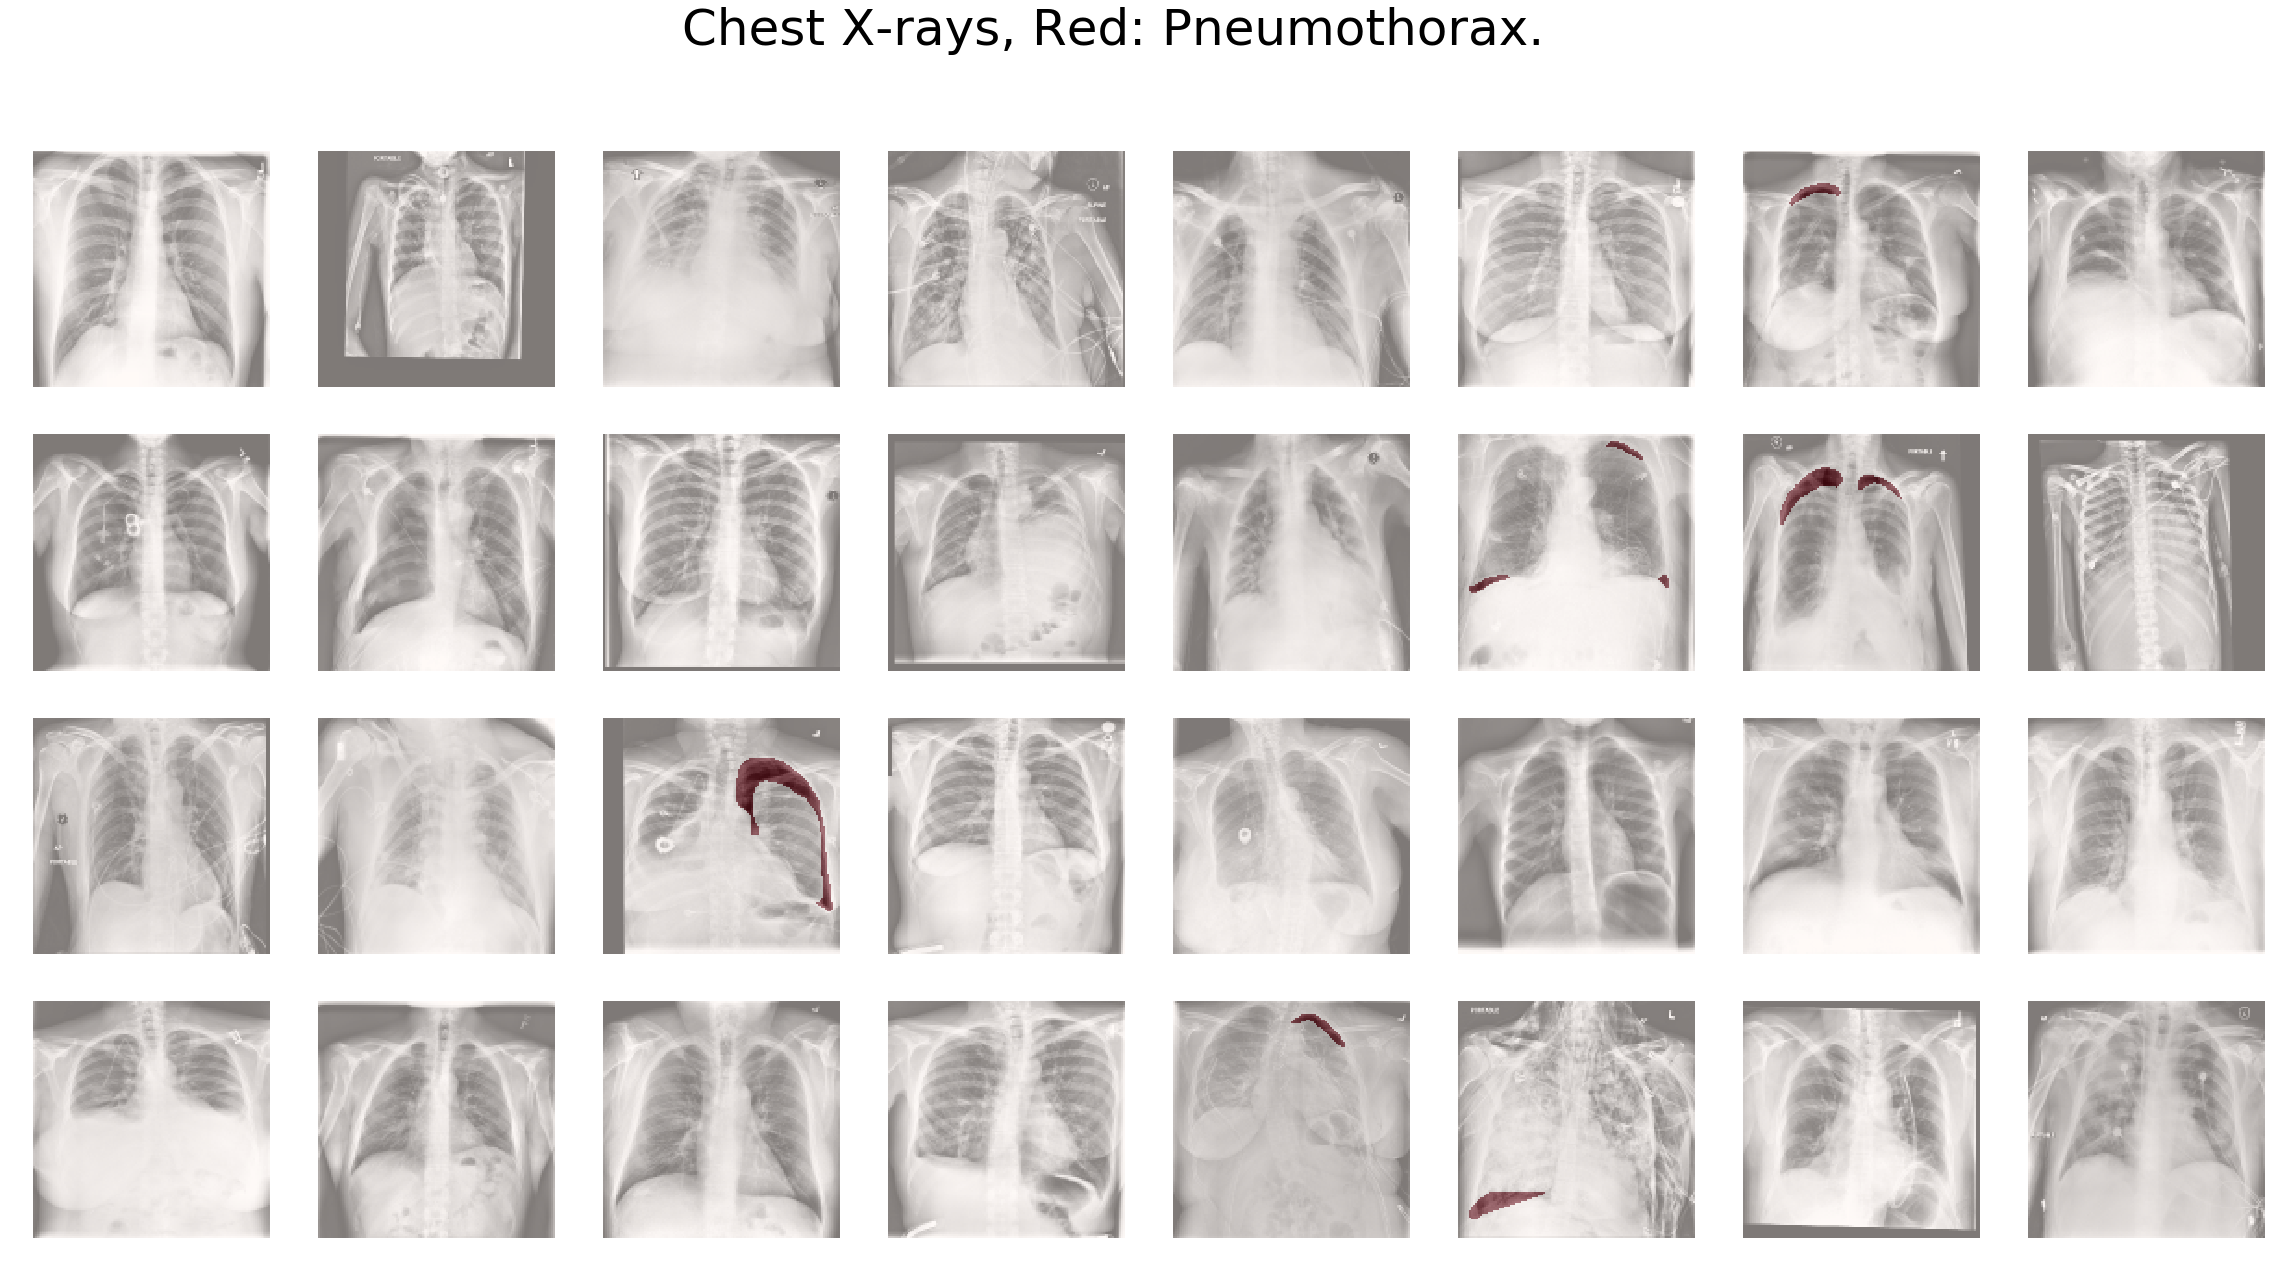

In [9]:
show_img = 32
a = Datagen(batch_size = show_img, shuffle = False)
images, masks = a.__getitem__(0)

fig_height = 4
fig_width = int(show_img/fig_height)
fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*5,fig_height*5))

for i, (im , mk) in enumerate(zip(images,masks)):
    ax = axes[int(i/fig_width),i%fig_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mk.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=50)    

In [10]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.1),
    OneOf([
        ElasticTransform(alpha=100, sigma=150 * 0.05, alpha_affine=150 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=0.5, shift_limit=0.5),
        ], p=0.2),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

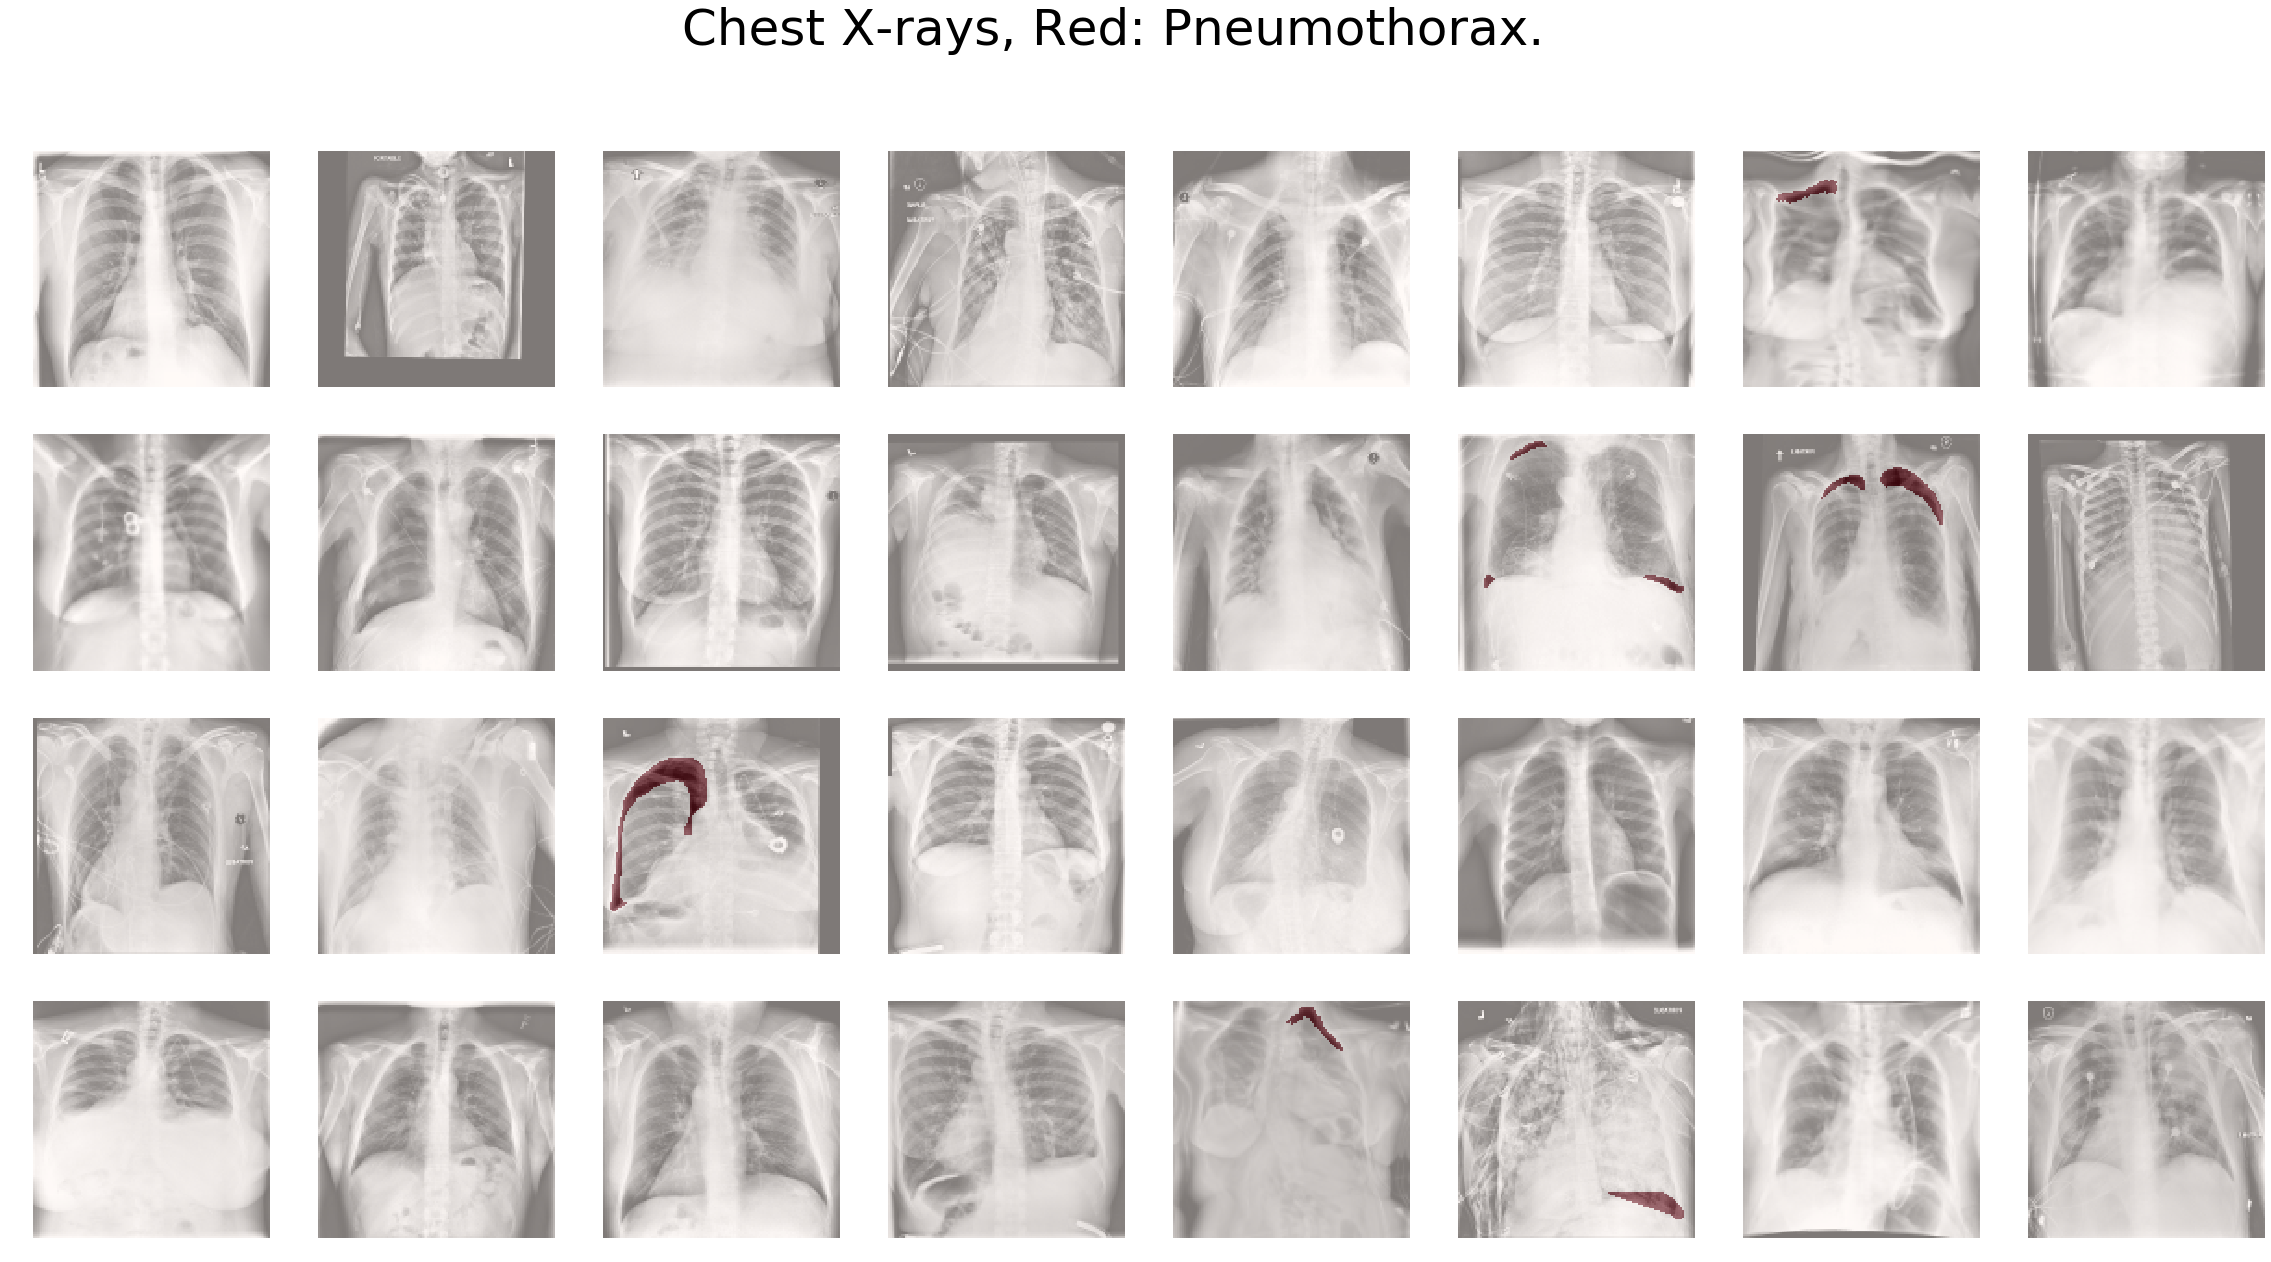

In [11]:
show_img = 32
a = Datagen(batch_size = show_img,augmentation = AUGMENTATIONS_TRAIN, shuffle = False)
images, masks = a.__getitem__(0)

fig_height = 4
fig_width = int(show_img/fig_height)
fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*5,fig_height*5))

for i, (im , mk) in enumerate(zip(images,masks)):
    ax = axes[int(i/fig_width),i%fig_width]
    ax.imshow(im.squeeze().astype('uint8'), cmap="bone")
    ax.imshow(mk.squeeze().astype('uint8'), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=50)   

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

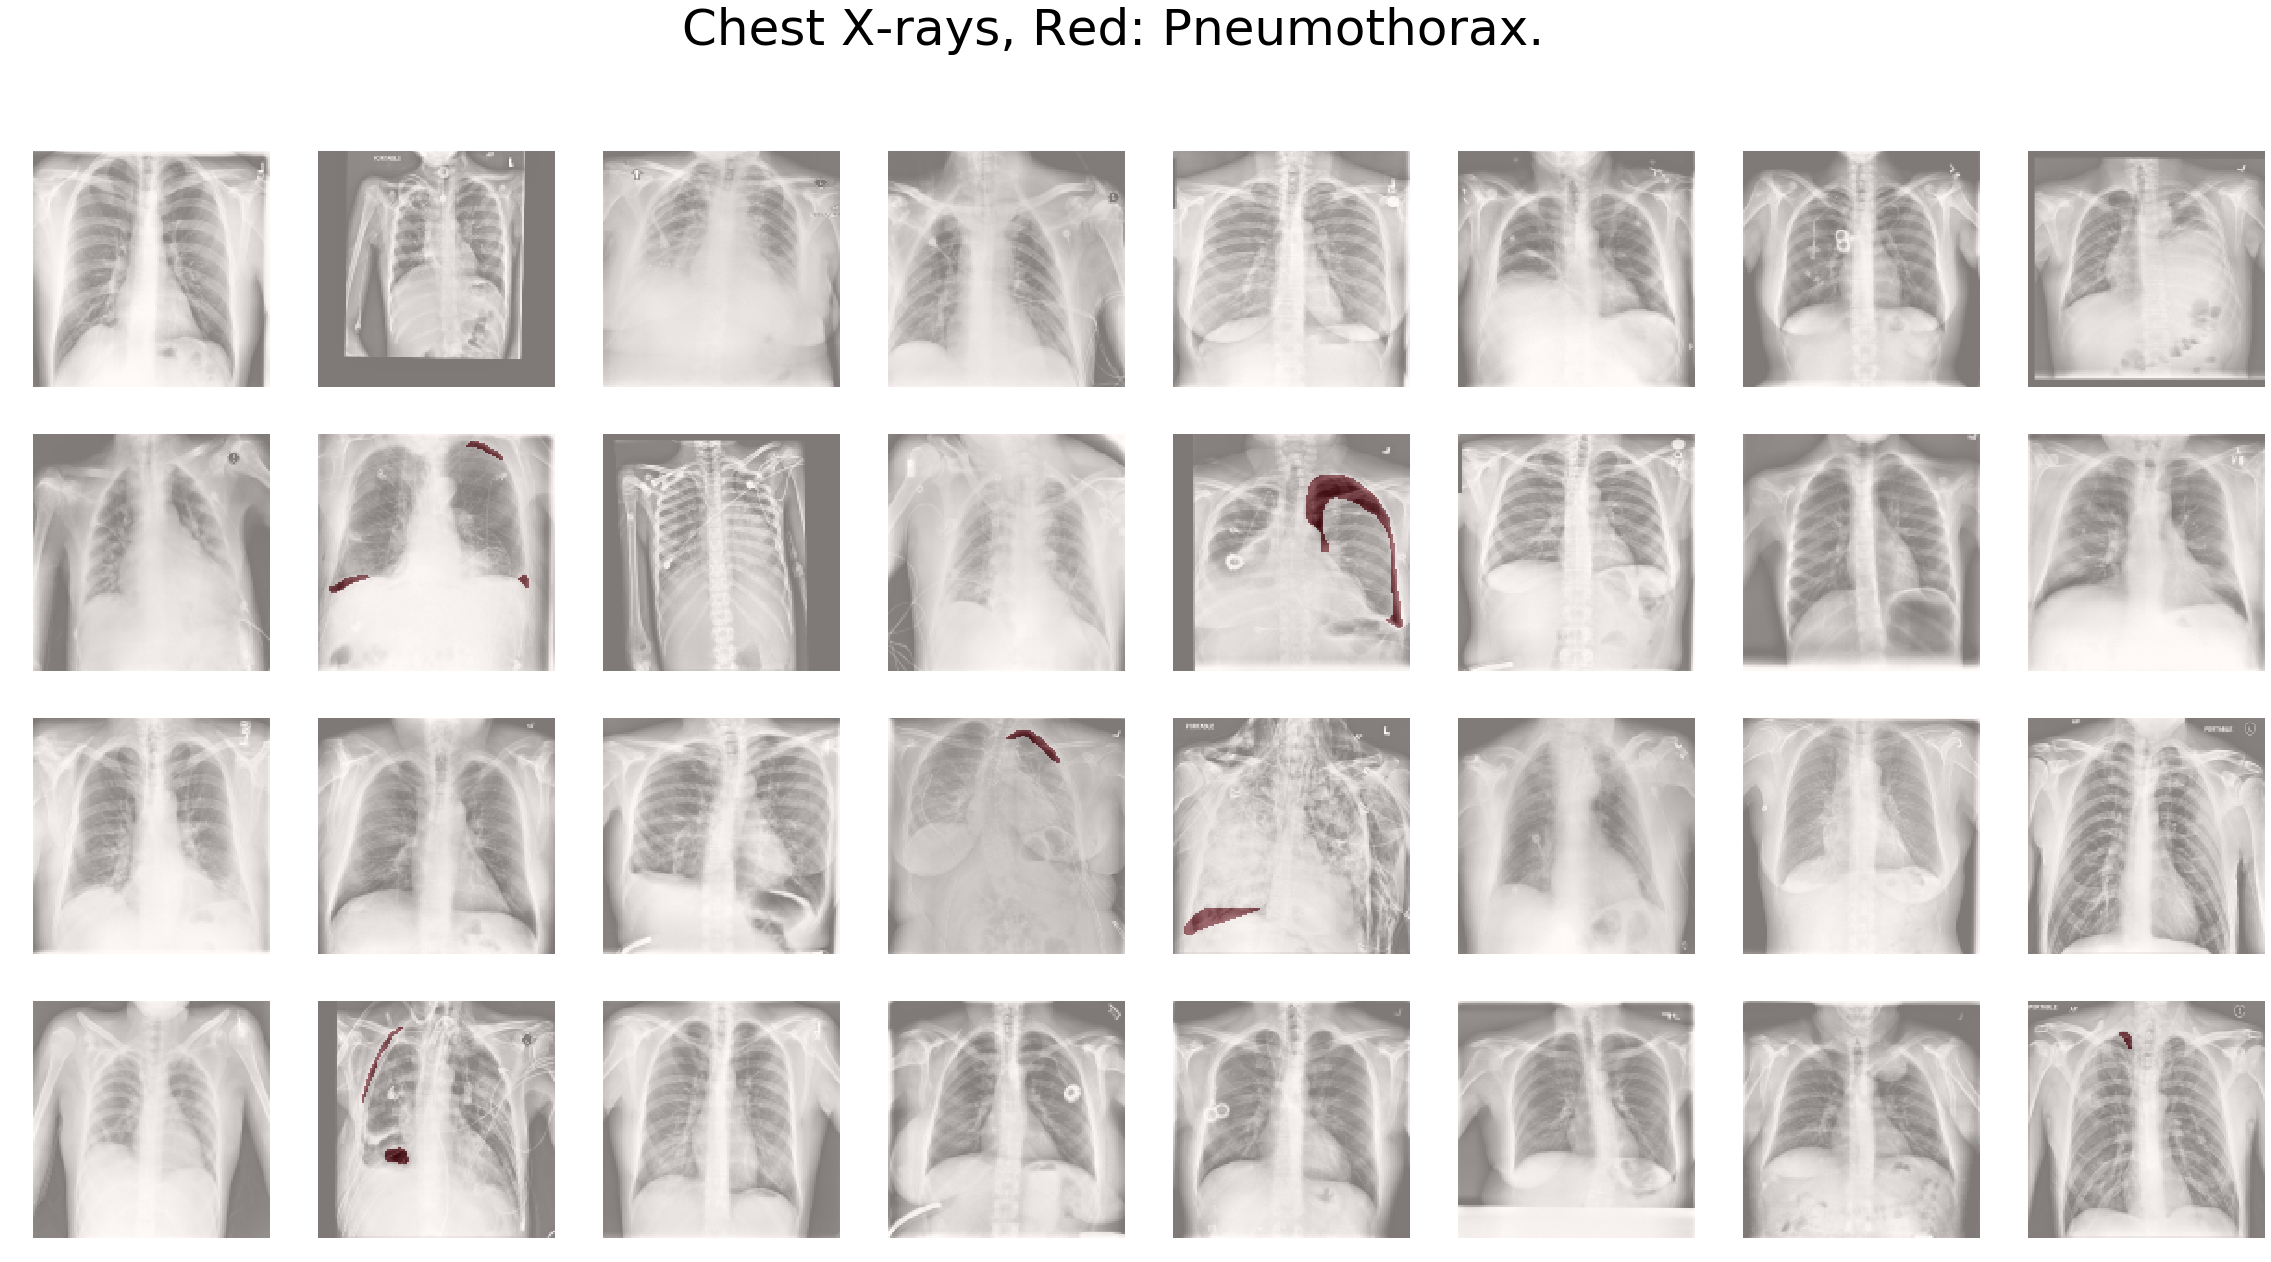

In [12]:
show_img = 32
a = Datagen(train_dir =VAL_DIR , mask_dir =VAL_MASK_DIR, batch_size = show_img,
            augmentation = AUGMENTATIONS_TEST, shuffle = False)
images, masks = a.__getitem__(0)

fig_height = 4
fig_width = int(show_img/fig_height)
fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*5,fig_height*5))

for i, (im , mk) in enumerate(zip(images,masks)):
    ax = axes[int(i/fig_width),i%fig_width]
    ax.imshow(im.squeeze().astype('uint8'), cmap="bone")
    ax.imshow(mk.squeeze().astype('uint8'), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=50)   

In [13]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    smooth = 1e-6
    B = B > 0.5
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        '''
        if true == 0:
            metric += (pred == 0)
            continue
        '''
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = (intersection+smooth) / (union+smooth)
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.5)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred], tf.float64)

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [15]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = BatchNormalization()(blockInput)
    x = LeakyReLU(alpha=0.1)(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

def attn_block(signal,blockInput):
    signal_shape = K.int_shape(signal)
    blockInput_shape = K.int_shape(blockInput)
    
    #signal = Conv2D(signal_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    #signal = BatchNormalization()(signal)
    #signal = LeakyReLU(alpha=0.1)(signal)
    
    signal = Conv2D(blockInput_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    theta_Input = Conv2D(blockInput_shape[3], (2,2), 
                         strides=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]), 
                         padding='same')(blockInput)
    
    Add_s_t = Add()([theta_Input, signal])
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('relu')(Add_s_t)
    Add_s_t = Conv2D(1, (1,1), strides=(1,1), padding='same')(Add_s_t)
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('sigmoid')(Add_s_t)
    
    Add_s_t = UpSampling2D(size=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]))(Add_s_t)
    
    OutputL = Multiply()([blockInput,Add_s_t])
    
    return OutputL

In [16]:
from efficientnet import EfficientNetB4


def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [17]:
ResNet50, preprocess_input = Classifiers.get('resnet50')
check = ResNet50((128,128,3), weights='imagenet',include_top=False)
print(check.get_layer('stage2_unit1_relu1').output)
print(check.get_layer('relu0').output)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("stage2_unit1_relu1/Relu:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("relu0/Relu:0", shape=(?, 64, 64, 64), dtype=float32)


In [18]:
def UResnet50(input_shape=(None, None, 3),dropout_rate=0.0):
    
    ResNet50, preprocess_input = Classifiers.get('resnet50')
    backbone = ResNet50(input_shape, weights='imagenet',include_top=False)
    
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.get_layer('stage4_unit1_relu1').output
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = BatchNormalization()(convm)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    #convm = backbone.get_layer('relu1').output
    Atten_conv4 = attn_block(convm,conv4)
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([Atten_conv4, deconv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    conv3 = backbone.get_layer('stage3_unit1_relu1').output
    Atten_conv3 = attn_block(uconv4,conv3)
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([Atten_conv3,deconv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)  
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    conv2 = backbone.get_layer('stage2_unit1_relu1').output
    Atten_conv2 = attn_block(uconv3,conv2)
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([Atten_conv2,deconv2]) 
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    conv1 = backbone.get_layer('relu0').output
    Atten_conv1 = attn_block(uconv2,conv1)
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([Atten_conv1,deconv1]) 
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = BatchNormalization()(uconv0)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [19]:
K.clear_session()
#model = UEfficientNet(input_shape=(image_size,image_size,channels),dropout_rate=0.5)
model = UResnet50(input_shape=(image_size,image_size,channels),dropout_rate=0.5)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]      

stage1_unit3_conv2 (Conv2D)     (None, 32, 32, 64)   36864       zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
stage1_unit3_bn3 (BatchNormaliz (None, 32, 32, 64)   256         stage1_unit3_conv2[0][0]         
__________________________________________________________________________________________________
stage1_unit3_relu3 (Activation) (None, 32, 32, 64)   0           stage1_unit3_bn3[0][0]           
__________________________________________________________________________________________________
stage1_unit3_conv3 (Conv2D)     (None, 32, 32, 256)  16384       stage1_unit3_relu3[0][0]         
__________________________________________________________________________________________________
add_3 (Add)                     (None, 32, 32, 256)  0           stage1_unit3_conv3[0][0]         
                                                                 add_2[0][0]                      
__________

stage2_unit4_bn1 (BatchNormaliz (None, 16, 16, 512)  2048        add_6[0][0]                      
__________________________________________________________________________________________________
stage2_unit4_relu1 (Activation) (None, 16, 16, 512)  0           stage2_unit4_bn1[0][0]           
__________________________________________________________________________________________________
stage2_unit4_conv1 (Conv2D)     (None, 16, 16, 128)  65536       stage2_unit4_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_bn2 (BatchNormaliz (None, 16, 16, 128)  512         stage2_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_relu2 (Activation) (None, 16, 16, 128)  0           stage2_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_paddi

__________________________________________________________________________________________________
stage3_unit3_conv2 (Conv2D)     (None, 8, 8, 256)    589824      zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
stage3_unit3_bn3 (BatchNormaliz (None, 8, 8, 256)    1024        stage3_unit3_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit3_relu3 (Activation) (None, 8, 8, 256)    0           stage3_unit3_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit3_conv3 (Conv2D)     (None, 8, 8, 1024)   262144      stage3_unit3_relu3[0][0]         
__________________________________________________________________________________________________
add_10 (Add)                    (None, 8, 8, 1024)   0           stage3_unit3_conv3[0][0]         
          

__________________________________________________________________________________________________
stage4_unit1_relu1 (Activation) (None, 8, 8, 1024)   0           stage4_unit1_bn1[0][0]           
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 4, 4, 1024)   0           stage4_unit1_relu1[0][0]         
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4, 4, 1024)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 512)    4719104     dropout_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4, 4, 512)    2048        conv2d_1[0][0]                   
__________

conv2d_10 (Conv2D)              (None, 8, 8, 256)    590080      leaky_re_lu_6[0][0]              
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 8, 8, 256)    1024        conv2d_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 8, 8, 256)    0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 8, 8, 256)    590080      leaky_re_lu_7[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 8, 8, 256)    1024        conv2d_11[0][0]                  
__________________________________________________________________________________________________
add_20 (Ad

batch_normalization_22 (BatchNo (None, 16, 16, 128)  512         add_23[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 16, 16, 128)  0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 128)  147584      leaky_re_lu_13[0][0]             
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16, 16, 128)  512         conv2d_20[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 16, 16, 128)  0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv2d_21 

__________________________________________________________________________________________________
add_27 (Add)                    (None, 32, 32, 64)   0           batch_normalization_33[0][0]     
                                                                 add_26[0][0]                     
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 32, 32, 64)   256         add_27[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, 32, 32, 64)   0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 64)   16448       relu0[0][0]                      
__________________________________________________________________________________________________
conv2d_30 

__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 128, 128, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_26 (LeakyReLU)      (None, 128, 128, 16) 0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        leaky_re_lu_26[0][0]             
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 128, 128, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 128, 128, 16) 0           batch_normalization_45[0][0]     
__________

In [20]:
model.compile(loss=dice_loss, optimizer='adam', metrics=[my_iou_metric])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [21]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save(self.filepath)
        print('Final stochastic averaged model saved to file.')

In [22]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(model_name+'.model',monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

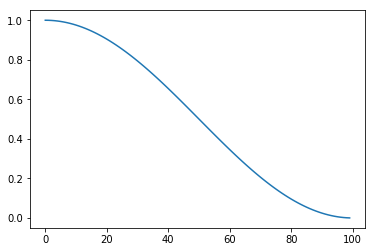

In [23]:
def _cosine_anneal_schedule_check(t):
    cos_inner = np.pi * (t % (epochs))/epochs 
    cos_out = np.cos(cos_inner) + 1
    return 1 / 2 * cos_out

x_info = np.arange(0,epochs)
plt.plot(x_info,_cosine_anneal_schedule_check(x_info))

In [24]:
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
swa = SWA(model_name+'_swa.model',swa_nb)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'

# Generators
training_generator = Datagen(augmentation=AUGMENTATIONS_TRAIN,image_size=image_size,batch_size=batch_size)

validation_generator = Datagen(train_dir = VAL_DIR, mask_dir=VAL_MASK_DIR,
                               augmentation=AUGMENTATIONS_TEST, image_size=image_size,batch_size=batch_size)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,  
                              use_multiprocessing=False,
                              epochs=epochs,verbose=2,
                              callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 5 epochs.
Epoch 1/100
 - 227s - loss: 0.9553 - my_iou_metric: 0.0364 - val_loss: 0.9944 - val_my_iou_metric: 7.6933e-04

Epoch 00001: val_my_iou_metric improved from -inf to 0.00077, saving model to ./res50attn_Rev2.model
Epoch 2/100
 - 184s - loss: 0.8645 - my_iou_metric: 0.2774 - val_loss: 0.9944 - val_my_iou_metric: 0.2671

Epoch 00002: val_my_iou_metric improved from 0.00077 to 0.26709, saving model to ./res50attn_Rev2.model
Epoch 3/100
 - 183s - loss: 0.8296 - my_iou_metric: 0.4212 - val_loss: 0.8401 - val_my_iou_metric: 0.5649

Epoch 00003: val_my_iou_metric improved from 0.26709 to 0.56489, saving model to ./res50attn_Rev2.model
Epoch 4/100
 - 183s - loss: 0.8063 - my_iou_metric: 0.4763 - val_loss: 0.9855 - val_my_iou_metric: 0.7676

Epoch 00004: val_my_iou_metric improved from 0.56489 to 0.76765, saving model to ./res50attn_Rev2.model
Epoch 5/100
 - 182s - loss: 0.7993 - my_iou_metric: 0.5034 - val_loss: 0.8061 - val_my_iou_metric: 

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


 - 182s - loss: 0.7018 - my_iou_metric: 0.6038 - val_loss: 0.8491 - val_my_iou_metric: 0.5579

Epoch 00023: val_my_iou_metric did not improve from 0.76765
Epoch 24/100
 - 182s - loss: 0.6969 - my_iou_metric: 0.6177 - val_loss: 0.7242 - val_my_iou_metric: 0.7246

Epoch 00024: val_my_iou_metric did not improve from 0.76765
Epoch 25/100
 - 182s - loss: 0.6914 - my_iou_metric: 0.6231 - val_loss: 0.9253 - val_my_iou_metric: 0.7613

Epoch 00025: val_my_iou_metric did not improve from 0.76765
Epoch 26/100
 - 182s - loss: 0.7024 - my_iou_metric: 0.5937 - val_loss: 0.6645 - val_my_iou_metric: 0.6103

Epoch 00026: val_my_iou_metric did not improve from 0.76765
Epoch 27/100
 - 182s - loss: 0.6816 - my_iou_metric: 0.6400 - val_loss: 0.7181 - val_my_iou_metric: 0.6812

Epoch 00027: val_my_iou_metric did not improve from 0.76765
Epoch 28/100
 - 182s - loss: 0.6894 - my_iou_metric: 0.6136 - val_loss: 0.7183 - val_my_iou_metric: 0.7056

Epoch 00028: val_my_iou_metric did not improve from 0.76765
Epoch


Epoch 00071: val_my_iou_metric did not improve from 0.77262
Epoch 72/100
 - 182s - loss: 0.5457 - my_iou_metric: 0.7267 - val_loss: 0.5192 - val_my_iou_metric: 0.7266

Epoch 00072: val_my_iou_metric did not improve from 0.77262
Epoch 73/100
 - 182s - loss: 0.5496 - my_iou_metric: 0.7252 - val_loss: 0.5145 - val_my_iou_metric: 0.7293

Epoch 00073: val_my_iou_metric did not improve from 0.77262
Epoch 74/100
 - 182s - loss: 0.5471 - my_iou_metric: 0.7317 - val_loss: 0.5278 - val_my_iou_metric: 0.7599

Epoch 00074: val_my_iou_metric did not improve from 0.77262
Epoch 75/100
 - 182s - loss: 0.5486 - my_iou_metric: 0.7244 - val_loss: 0.5189 - val_my_iou_metric: 0.7287

Epoch 00075: val_my_iou_metric did not improve from 0.77262
Epoch 76/100
 - 182s - loss: 0.5389 - my_iou_metric: 0.7340 - val_loss: 0.5183 - val_my_iou_metric: 0.7616

Epoch 00076: val_my_iou_metric did not improve from 0.77262
Epoch 77/100
 - 182s - loss: 0.5378 - my_iou_metric: 0.7326 - val_loss: 0.5036 - val_my_iou_metric:

Text(0.5, 1.0, 'model loss')

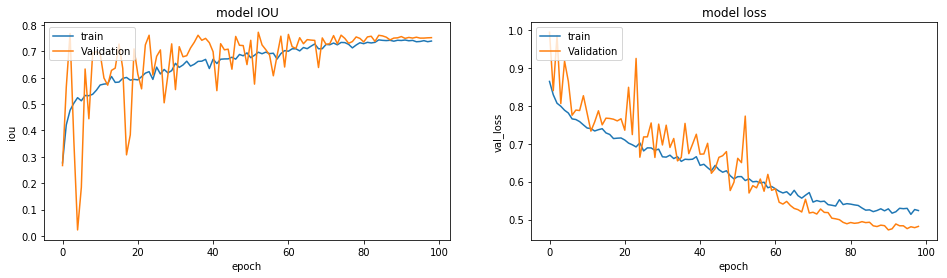

In [25]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
#gc.collect()

In [26]:
# Load best model or swa model if not available
try:
    print('using swa weight model')
    model.load_weights(model_name+'_swa.model')
except Exception as e:
    print(e)
    model.load_weights(model_name+'.model')

using swa weight model


In [27]:
def predict_result(model,validation_generator,img_size): 
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [28]:
validation_generator = Datagen(train_dir = VAL_DIR, mask_dir = VAL_MASK_DIR,
                               augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,shuffle=False)

AUGMENTATIONS_TEST_FLIPPED = Compose([
    HorizontalFlip(p=1),
    ToFloat(max_value=1)
],p=1)

validation_generator_flipped = Datagen(train_dir = VAL_DIR, mask_dir=VAL_MASK_DIR,
                                       augmentation=AUGMENTATIONS_TEST_FLIPPED,
                                       image_size=image_size,shuffle=False)

preds_valid_orig = predict_result(model,validation_generator,image_size)
preds_valid_flipped = predict_result(model,validation_generator_flipped,image_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [29]:
len(preds_valid_flipped)

7799

In [30]:
valid_fn = glob.glob('./im_mask_val/*')
len(valid_fn)

7799

In [31]:
valid_fn = glob.glob('./im_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(image_size,image_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

In [32]:
def cal_iou(y_true_in, y_pred_in):
    smooth = 1e-6
    y_true_in = y_true_in.astype('bool')
    true = np.sum(y_true_in)
    pred = np.sum(y_pred_in)
    intersection = np.sum(y_true_in * y_pred_in)
    union = true + pred - intersection
    iou = (intersection+smooth) / (union+smooth)
    iou = np.floor(max(0, (iou - 0.5)*20)) / 10
    return iou

def cal_iou_metric(y_true_in, y_pred_in):
    metric = []
    for y_t, y_p in zip(y_true_in,y_pred_in):
        metric.append(cal_iou(y_t,y_p))
    return np.mean(metric)

In [33]:
thresholds = np.linspace(0.2, 0.9, 31)
iou_calculated = np.array([cal_iou_metric(y_valid_ori,preds_valid>threshold) for threshold in tqdm_notebook(thresholds)])

26


Text(0.5, 1.0, 'Threshold vs IoU (0.8066666666666666, 0.7750609052442622)')

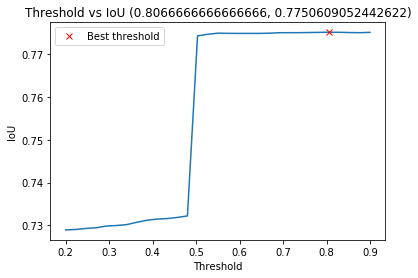

In [34]:
threshold_best_index = np.argmax(iou_calculated) 
print(threshold_best_index)
iou_best = iou_calculated[threshold_best_index]
threshold_best_cal = thresholds[threshold_best_index]

plt.figure()
plt.plot(thresholds,iou_calculated)
plt.plot(threshold_best_cal,iou_best,'xr', label="Best threshold")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best_cal, iou_best))

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

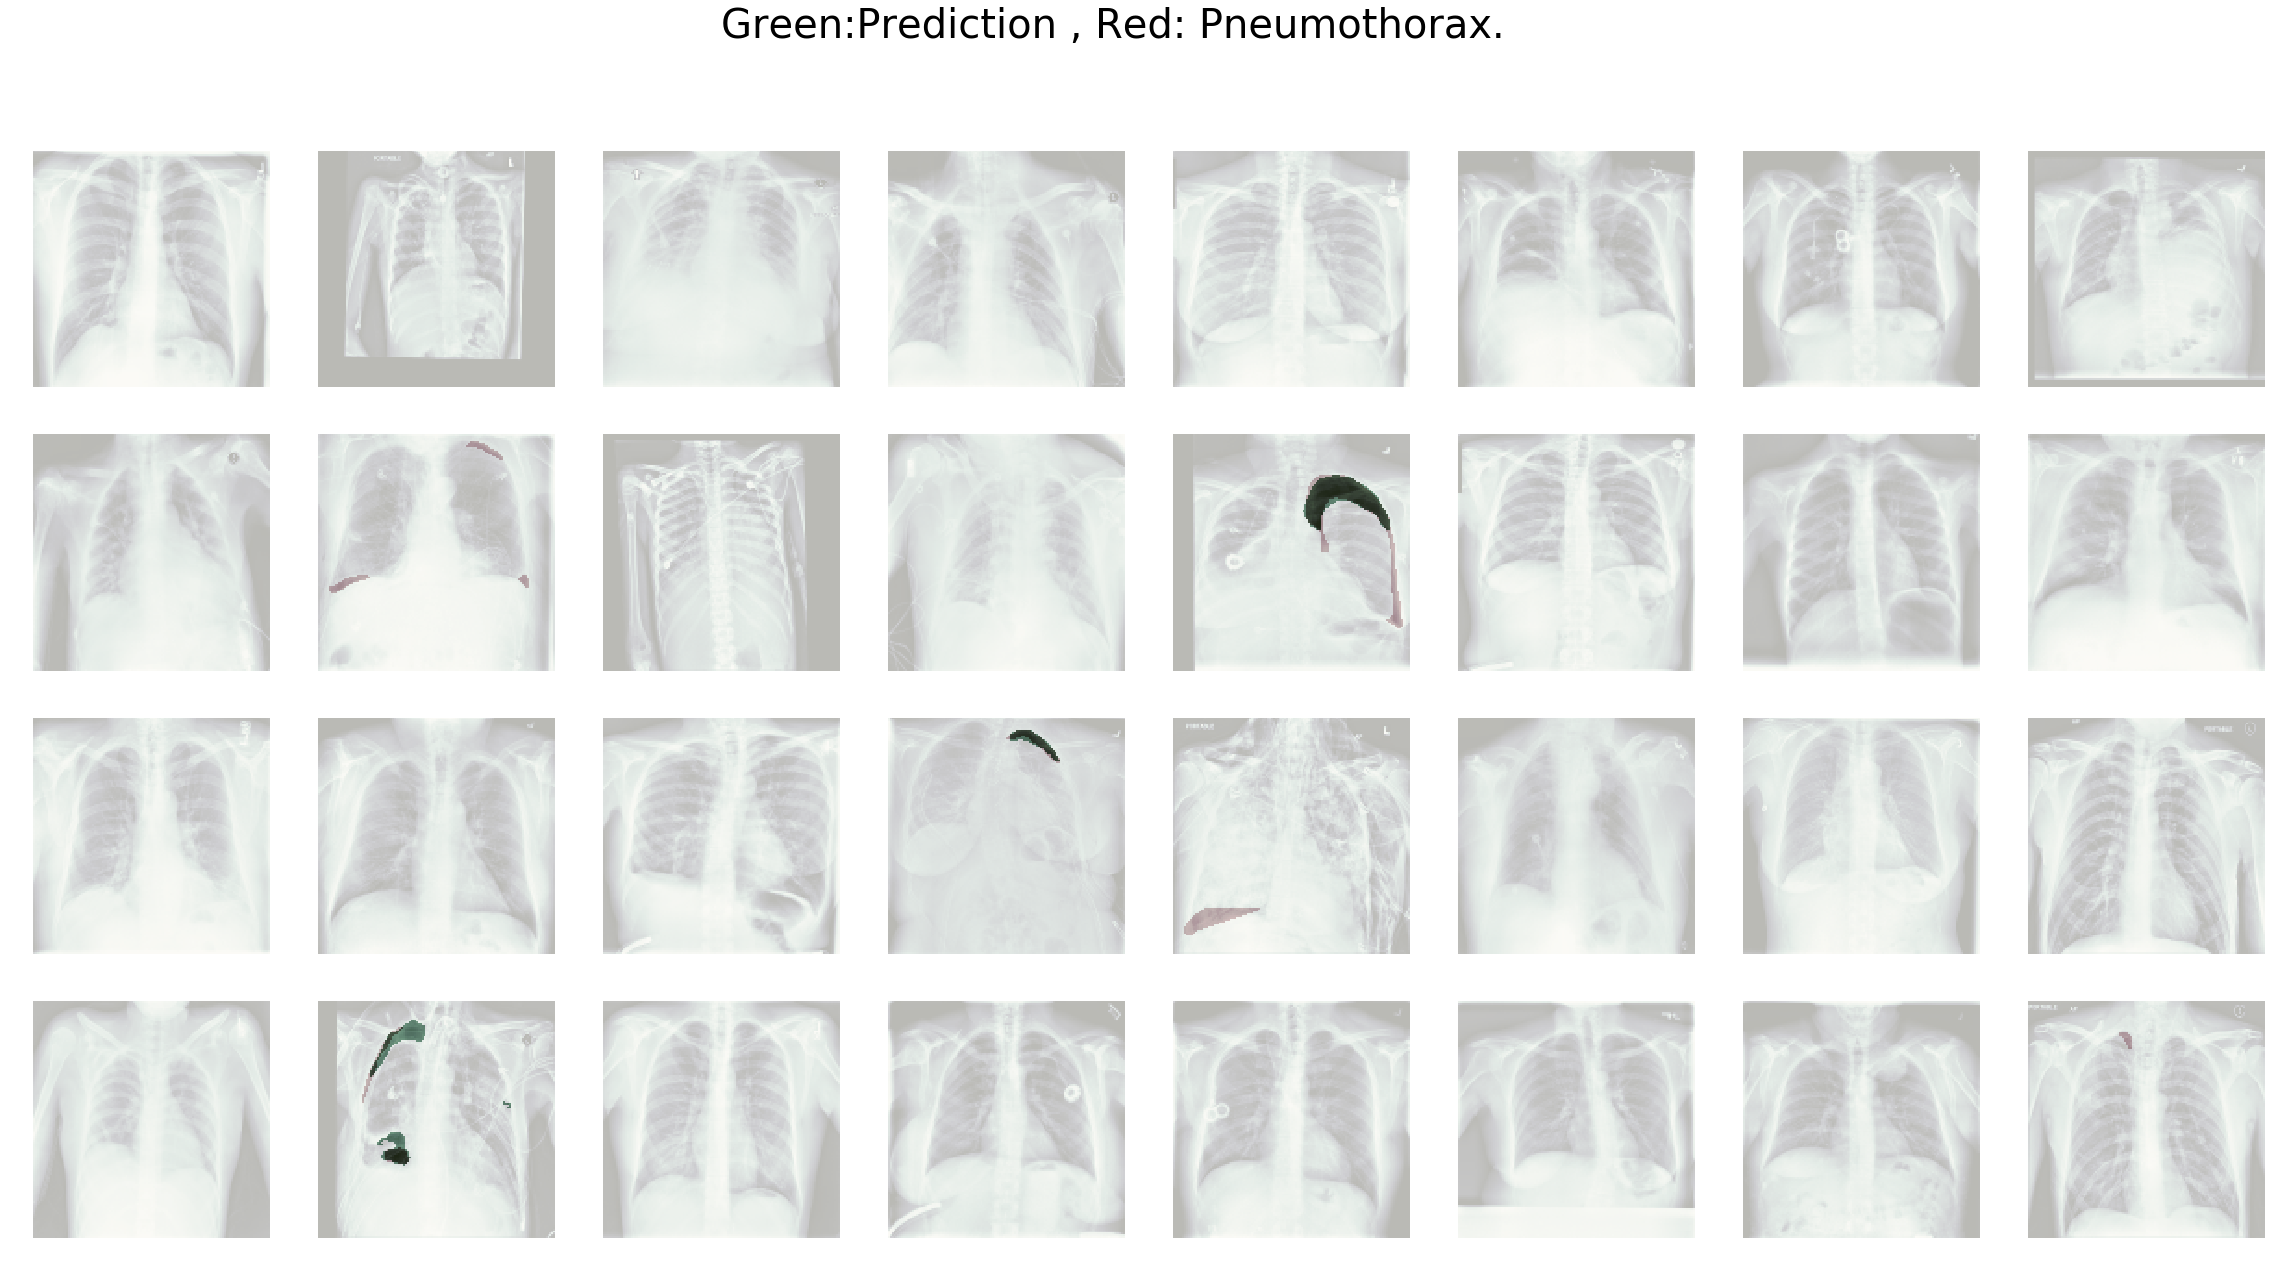

In [35]:
threshold_best = 0.5
max_images = 32
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5, grid_height*5))

validation_generator = Datagen(train_dir = VAL_DIR,
                               mask_dir=VAL_MASK_DIR,augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,batch_size=max_images,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.",fontsize = 40)

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

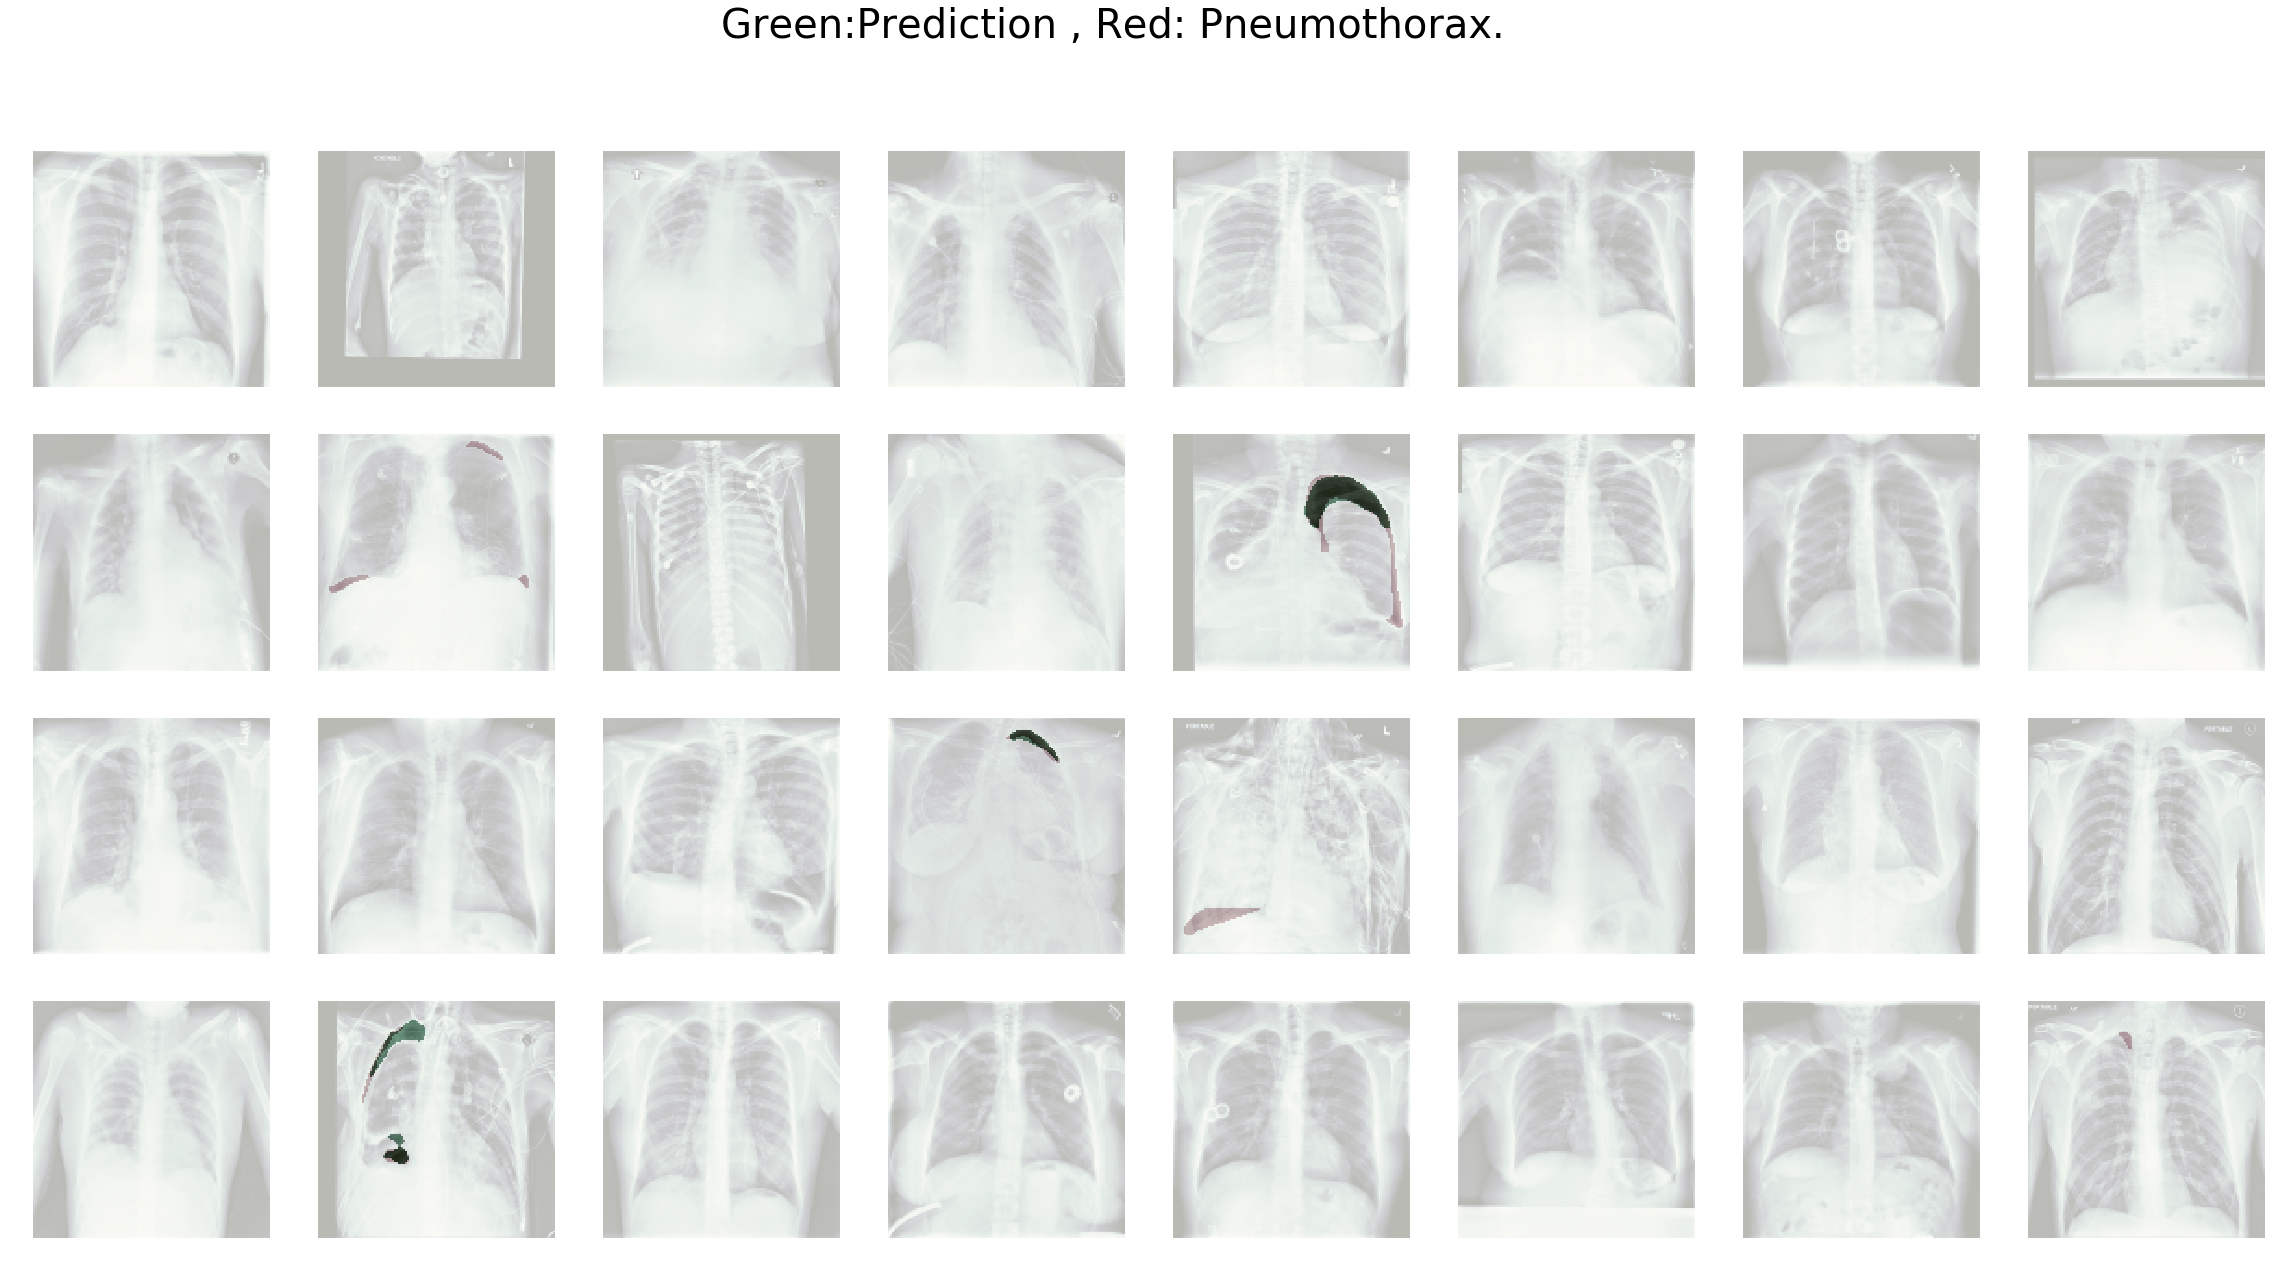

In [36]:
threshold_best = threshold_best_cal
max_images = 32
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5, grid_height*5))

validation_generator = Datagen(train_dir = VAL_DIR,
                               mask_dir=VAL_MASK_DIR,augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,batch_size=max_images,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.",fontsize = 40)

In [37]:
test_fn = glob.glob('./results/test/*')
test_img = np.array([cv2.resize(np.array(Image.open(fn)),(image_size,image_size)) for fn in tqdm_notebook(test_fn)])
test_img = np.array([np.repeat(test_img_item[...,None],3,2) for test_img_item in tqdm_notebook(test_img)])
print(test_img.shape)

predict_test = model.predict(test_img,batch_size=batch_size)


(3205, 128, 128, 3)


Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

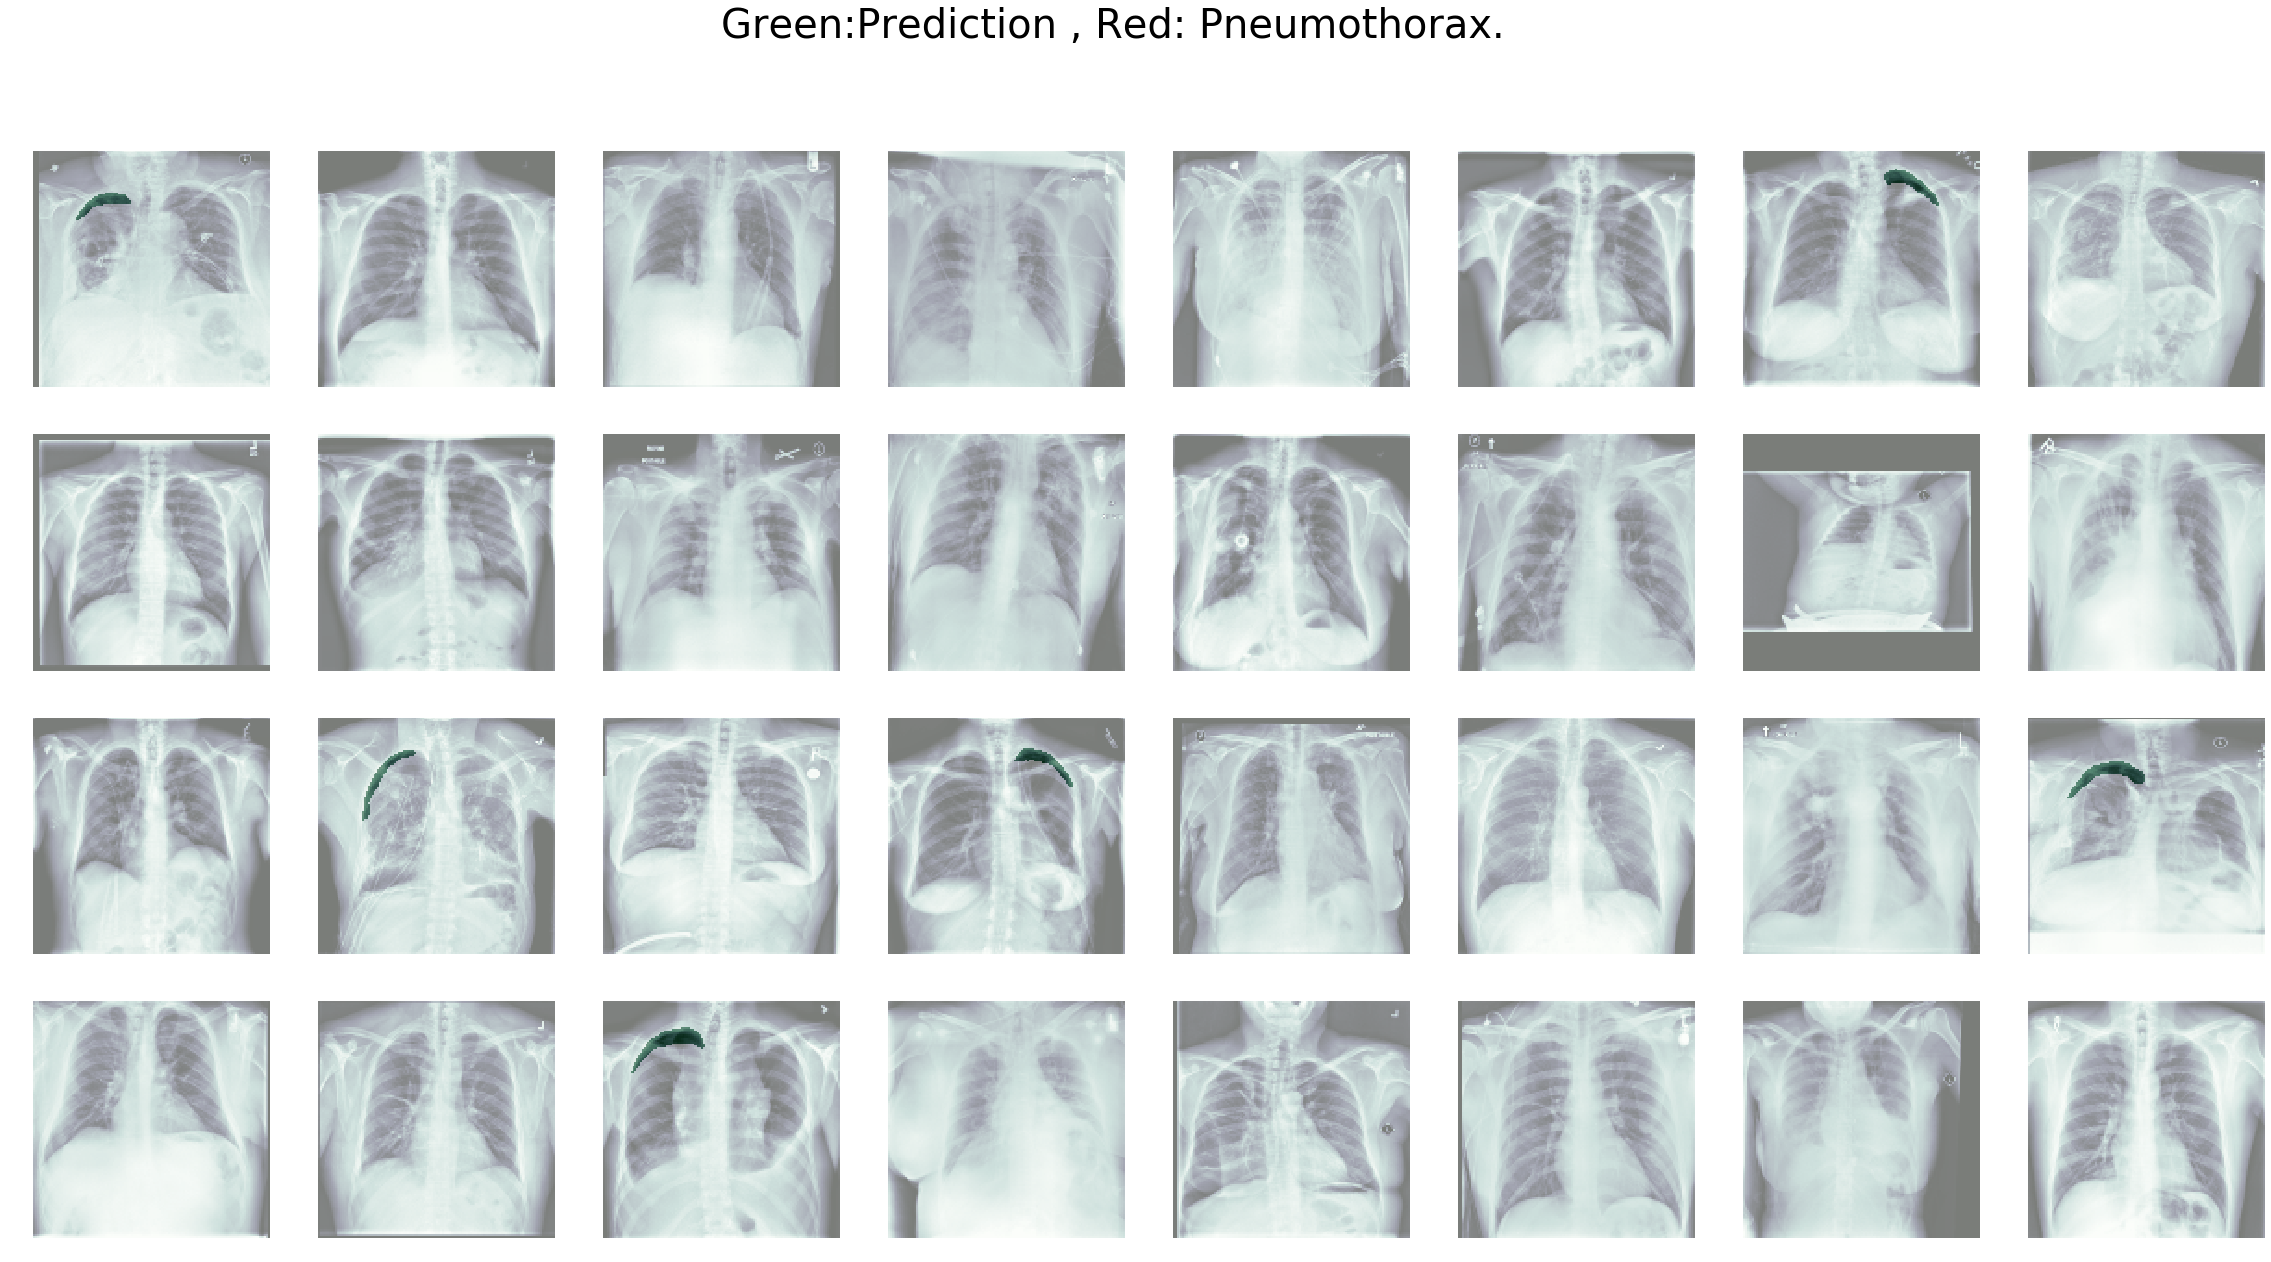

In [38]:
threshold_best = threshold_best_cal
max_images = 32
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5, grid_height*5))

for i in range(max_images):
    pred = predict_test[i].squeeze()   
    im = test_img[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")  
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.",fontsize = 40)

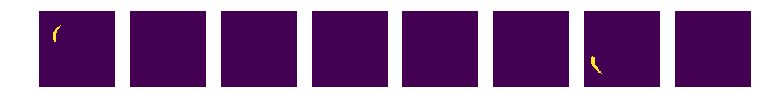

In [39]:
test_result = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(predict_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    test_result.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [40]:
ids = [id.split('\\')[-1][:-4] for id in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': test_result})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head(10)

ImageId                                      EncodedPixels
0  ID_0011fe81e  190756 8 1015 10 1013 12 1012 12 1012 12 1011 ...
1  ID_003206608                                                 -1
2  ID_004d6fbb6                                                 -1
3  ID_004d72c54                                                 -1
4  ID_00528aa0e                                                 -1
5  ID_00593ac6d                                                 -1
6  ID_00b0e5a9f  624748 16 1007 18 1005 20 1004 20 1004 20 1003...
7  ID_00b115bfe                                                 -1
8  ID_00d054471                                                 -1
9  ID_00f04769e                                                 -1

In [41]:
sub_df.to_csv(model_name.split('/')[-1]+'submission.csv', index=False)

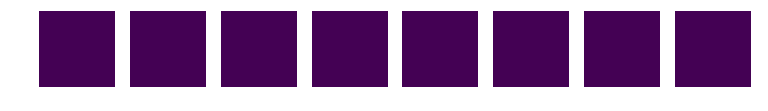

In [42]:
model.load_weights(model_name+'.model')
predict_test = model.predict(test_img,batch_size=batch_size)

test_result = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(predict_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    test_result.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [43]:
sub_df2 = pd.DataFrame({'ImageId': ids, 'EncodedPixels': test_result})
sub_df2.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df2.head(10)
sub_df2.to_csv(model_name.split('/')[-1]+'_base_submission.csv', index=False)